# Neural Networks

#### Neural network is a network or circuit of biological neurons and composed of artificial neurons or nodes. It is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that is similar to the way the human brain operates.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse

import warnings
warnings.filterwarnings("ignore")

# yahoo finance is used to fetch data 
import yfinance as yf
yf.pdr_override()

In [2]:
symbol = 'MSFT'
start = '2018-01-01'
end = '2022-11-10'


# Read data 
df = yf.download(symbol,start,end)

# View Columns
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02 00:00:00-05:00,86.129997,86.309998,85.500000,85.949997,81.168518,22483800
2018-01-03 00:00:00-05:00,86.059998,86.510002,85.970001,86.349998,81.546249,26061400
2018-01-04 00:00:00-05:00,86.589996,87.660004,86.570000,87.110001,82.263977,21912000
2018-01-05 00:00:00-05:00,87.660004,88.410004,87.430000,88.190002,83.283890,23407100
2018-01-08 00:00:00-05:00,88.199997,88.580002,87.599998,88.279999,83.368866,22113000


In [3]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-03 00:00:00-04:00,220.089996,220.410004,213.979996,214.250000,214.250000,36633900
2022-11-04 00:00:00-04:00,217.550003,221.589996,213.429993,221.389999,221.389999,36767800
2022-11-07 00:00:00-05:00,221.990005,228.410004,221.279999,227.869995,227.869995,33498000
2022-11-08 00:00:00-05:00,228.699997,231.649994,225.839996,228.869995,228.869995,28192500
2022-11-09 00:00:00-05:00,227.369995,228.630005,224.330002,224.509995,224.509995,27852900


In [4]:
ret = 100 * (df.pct_change()[1:]['Adj Close'])
realized_vol = ret.rolling(5).std()

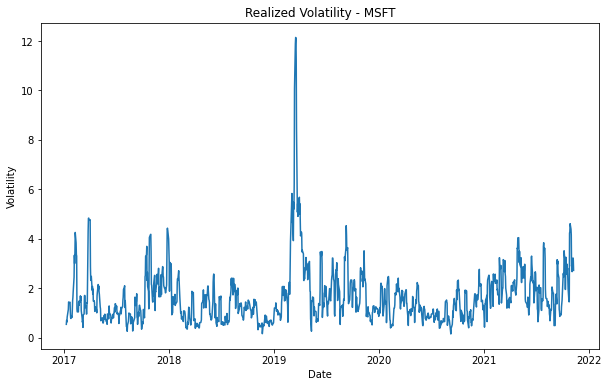

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility - ' + symbol)
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [6]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

In [7]:
returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['Date']

In [8]:
 X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
 X = X[4:].copy()
 X = X.reset_index()
 X.drop('index', axis=1, inplace=True)

In [9]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

In [10]:
n = 252
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)

para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
 'max_iter': [500, 1000],
 'alpha': [0.00005, 0.0005 ]}

clf = RandomizedSearchCV(NN_vol, para_grid_NN)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))

predictions = clf.predict(X.iloc[-n:])

In [11]:
predictions = pd.DataFrame(predictions)
predictions.index = ret.iloc[-n:].index

In [12]:
predictions

,0
Date,
2021-11-10 00:00:00-05:00,1.015868
2021-11-11 00:00:00-05:00,0.836410
2021-11-12 00:00:00-05:00,1.117513
2021-11-15 00:00:00-05:00,1.030438
2021-11-16 00:00:00-05:00,1.136596
...,...
2022-11-03 00:00:00-04:00,2.754927
2022-11-04 00:00:00-04:00,2.713711
2022-11-07 00:00:00-05:00,3.004522


In [13]:
realized_vol 

,Adj Close
0,0.541096
1,0.698926
2,0.631679
3,0.832579
4,1.142363
...,...
1214,2.966618
1215,2.670685
1216,3.225606
1217,3.138010


In [14]:
rmse = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predictions / 100))

print('The RMSE value of Neural Network is {:.6f}'.format(rmse))


The RMSE value of Neural Network is 0.001746


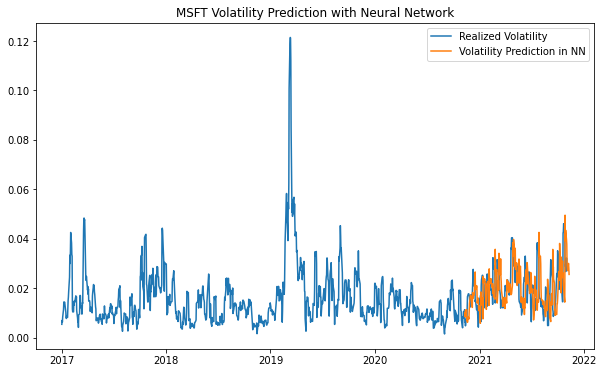

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:1219], realized_vol / 100, label='Realized Volatility')
plt.plot(predictions / 100, label='Volatility Prediction in NN')
plt.title(symbol + ' Volatility Prediction with Neural Network', fontsize=12)
plt.legend(loc='best')
plt.show()